In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import lightgbm as lgb
from sklearn.model_selection import KFold
from imblearn.metrics import  geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [88]:
df = pd.read_csv('C:/Users/kanka/OneDrive/Desktop/Final Project/Datasets/credit.csv',  delimiter=',')

df



,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Class
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [89]:
print(df['Class'].value_counts())

0    23364
1     6636
Name: Class, dtype: int64


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Class        0
dtype: int64


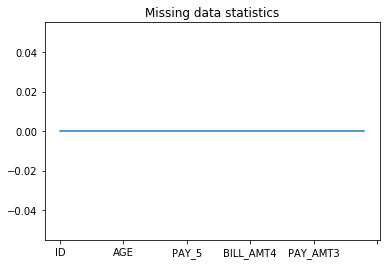

In [91]:
c = df.isnull().sum()
plt.title("Missing data statistics")
c.plot(kind='line')
print(c)

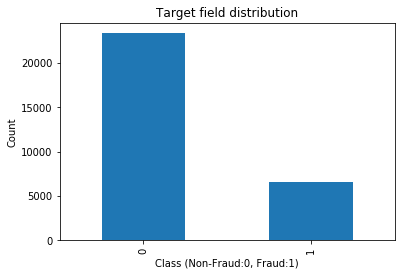

In [92]:
df['Class'].value_counts().plot(kind='bar', title='Target field distribution');
plt.ylabel('Count')
plt.xlabel('Class (Non-Fraud:0, Fraud:1)')
plt.show()

Count of Non-Default clients 23364
Count of Default clients 6636


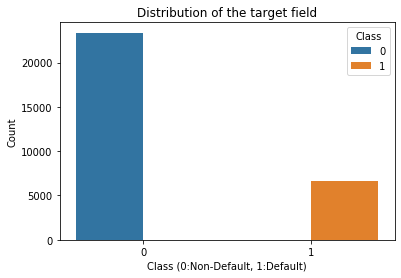

In [93]:
Non_default, Default = df['Class'].value_counts()
print('Count of Non-Default clients', Non_default)
print('Count of Default clients', Default)
sns.countplot(x="Class", hue="Class", data=df)
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Default, 1:Default)')
plt.title('Distribution of the target field')
plt.show()

In [94]:
df.shape

(30000, 25)

In [95]:
df = df[(df['LIMIT_BAL'] >= 0) & (df['BILL_AMT1'] >= 0) & (df['BILL_AMT2'] >= 0) & (df['BILL_AMT3'] >= 0) & (df['BILL_AMT4'] >= 0) &
        (df['BILL_AMT5'] >= 0)& (df['BILL_AMT6'] >= 0) & (df['PAY_AMT1'] >= 0) & (df['PAY_AMT2'] >= 0) & 
        (df['PAY_AMT3'] >= 0) & (df['PAY_AMT4'] >= 0) & (df['PAY_AMT5'] >= 0) & (df['PAY_AMT6'] >= 0)]

In [96]:
df.shape

(28070, 25)

In [97]:
data = df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
           'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
           'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']] = scaler.fit_transform(data)

df

C:\Users\kanka\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kanka\Anaconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Class
0,1,-1.119864,2,2,1,24,2,2,-1,-1,...,-0.696703,-0.686619,-0.677370,-0.348383,-0.258185,-0.302135,-0.319376,-0.326208,-0.294673,1
1,2,-0.344569,2,2,2,26,-1,2,0,0,...,-0.646623,-0.630644,-0.623351,-0.348383,-0.242362,-0.243697,-0.251699,-0.326208,-0.178969,1
2,3,-0.577157,2,2,2,34,0,0,0,0,...,-0.477357,-0.444443,-0.419798,-0.255306,-0.216923,-0.243697,-0.251699,-0.257342,-0.005413,0
3,4,-0.887275,2,2,1,37,0,0,0,0,...,-0.263337,-0.217448,-0.187919,-0.225752,-0.190517,-0.232010,-0.244931,-0.252590,-0.236821,0
4,5,-0.887275,1,2,1,57,-1,0,-1,0,...,-0.376202,-0.376430,-0.360462,-0.225752,1.573007,0.282246,0.289718,-0.278759,-0.255391,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,29995,-0.654687,1,2,2,34,2,2,2,2,...,0.489780,0.651715,0.667027,0.080826,-0.115168,-0.302135,0.154364,-0.326208,-0.063265,1
29995,29996,0.430727,1,3,1,39,0,0,0,0,...,0.650261,-0.180542,-0.412659,0.172800,0.724315,-0.009770,-0.113164,0.018122,-0.236821,0
29996,29997,-0.111980,1,3,2,43,-1,-1,-1,-1,...,-0.559273,-0.602535,-0.677370,-0.235746,-0.113845,0.223691,-0.310645,-0.326208,-0.294673,0
29997,29998,-1.042334,1,2,2,37,4,3,2,-1,...,-0.377151,-0.353165,-0.356718,-0.348383,-0.293240,0.983502,-0.035132,-0.188476,-0.115332,1


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28070 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         28070 non-null  int64  
 1   LIMIT_BAL  28070 non-null  float64
 2   SEX        28070 non-null  int64  
 3   EDUCATION  28070 non-null  int64  
 4   MARRIAGE   28070 non-null  int64  
 5   AGE        28070 non-null  int64  
 6   PAY_0      28070 non-null  int64  
 7   PAY_2      28070 non-null  int64  
 8   PAY_3      28070 non-null  int64  
 9   PAY_4      28070 non-null  int64  
 10  PAY_5      28070 non-null  int64  
 11  PAY_6      28070 non-null  int64  
 12  BILL_AMT1  28070 non-null  float64
 13  BILL_AMT2  28070 non-null  float64
 14  BILL_AMT3  28070 non-null  float64
 15  BILL_AMT4  28070 non-null  float64
 16  BILL_AMT5  28070 non-null  float64
 17  BILL_AMT6  28070 non-null  float64
 18  PAY_AMT1   28070 non-null  float64
 19  PAY_AMT2   28070 non-null  float64
 20  PAY_AM

In [100]:
y = df['Class']
x = df.drop(['Class','ID'],axis=1)
print(x)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      -1.119864    2          2         1   24      2      2     -1     -1   
1      -0.344569    2          2         2   26     -1      2      0      0   
2      -0.577157    2          2         2   34      0      0      0      0   
3      -0.887275    2          2         1   37      0      0      0      0   
4      -0.887275    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29994  -0.654687    1          2         2   34      2      2      2      2   
29995   0.430727    1          3         1   39      0      0      0      0   
29996  -0.111980    1          3         2   43     -1     -1     -1     -1   
29997  -1.042334    1          2         2   37      4      3      2     -1   
29999  -0.887275    1          2         1   46      0      0      0      0   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5 

# AIS Algorithm functions

In [101]:
def initilization_of_population_featurebased(size,n_feat):
    population = []
    #chromosome = []
    for j in range(size): 
        chromosome = []    #chromosome type is list
        for i in range(n_feat):
            if i == 0:
                gene = round(random.uniform(-0.34, -1.11),4)
            elif i == 1:
                gene = random.randint(1, 2)
            elif i == 2:
                gene = random.randint(1,2)
            elif i == 3:
                gene = random.randint(1,2)
            elif i == 4:
                gene = random.randint(22,43)
            elif i == 5:
                gene = random.randint(-1,2)
            elif i == 6:
                gene = random.randint(-1,2)
            elif i == 7:
                gene = random.randint(-1,2)
            elif i == 8:
                gene = random.randint(-1,2)
            elif i == 9:
                gene = random.randint(-1,2)
            elif i == 10:
                gene = random.randint(-1,2)
            elif i == 11:
                gene = round(random.uniform(-0.13, 0.48),4)
            elif i == 12:
                gene = round(random.uniform(-0.68, 0.4),4)
            elif i == 13:
                gene = round(random.uniform(-0.07, 0.4),2)
            elif i == 14:
                gene = round(random.uniform(-0.1,0.48),4)
            elif i == 15:
                gene = round(random.uniform(-0.16,0.65),4)
            elif i == 16:
                gene = round(random.uniform(-0.3,0.66),4)
            elif i == 17:
                gene = round(random.uniform(-0.2,0.08),4)
            elif i == 18:
                gene = round(random.uniform(-0.2,0.1),4)
            elif i == 19:
                gene = round(random.uniform(-0.2,0.98),4)
            elif i == 20:
                gene = round(random.uniform(-0.03,0.15),4)
            elif i == 21:
                gene = round(random.uniform(-0.1,-0.3),4)
            else:
                gene =  round(random.uniform(-0.06,-0.29),4)
            chromosome.append(gene)
        population.append(chromosome)
    return(population)

In [74]:
t = initilization_of_population_featurebased(2,23)

print(t)

type(t)

[[-1.0914, 1, 2, 1, 23, -1, 0, -1, 2, -1, -1, -0.0918, 0.358, 0.14, -0.0638, -0.0202, 0.375, -0.0103, -0.1935, 0.9687, 0.1432, -0.267, -0.2611], [-0.929, 2, 1, 1, 27, 0, 0, -1, -1, 0, 1, 0.1856, -0.0599, -0.07, -0.0177, 0.0339, 0.1146, -0.1635, 0.0846, 0.2369, 0.008, -0.1363, -0.1424]]


list

In [102]:
def fitness_score(population,model,X_train,X_test, y_train, y_test):
    scores = []
    for chromosome in population:
        a_series = pd.Series(chromosome, index = X_train.columns)
        X_train_with_chromosome = X_train.append(a_series, ignore_index=True)
        y_train_with_chromosome = y_train.append(pd.DataFrame([1]))
        model.fit(X_train_with_chromosome,np.ravel(y_train_with_chromosome))
        predictions = model.predict(X_test)
        scores.append(f1_score(np.ravel(y_test), predictions))
    scores, population = np.array(scores), np.array(population) # list of arrays scores = [[array1],[array2]]
    inds = np.argsort(scores) #[2, 3, 1, 0] indicates that the smallest element is at index 2, the next smallest at index 3, then index 1, then index 0.
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) #list of list (converting each array such as array, array2  0 to list in sorted order)

In [103]:
def selection(pop_after_fit,n_parents):
    population_nextgen = [] #New array 
    for i in range(n_parents): 
        population_nextgen.append(pop_after_fit[i])  # append the best chromosomes as parents from results after fit function
    return population_nextgen 

In [104]:
def clone(pop_after_sel, clone_rate):
    population_next_gen_cloned = []
    population_next_gen=pop_after_sel
    for x in range(clone_rate):
            for i in range(len(population_next_gen)):
                clones = population_next_gen[i]
                population_next_gen_cloned.append(clones)
    return population_next_gen_cloned
    

In [105]:
def mutation_clone(pop_after_clone,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_clone)):  #consider each chromoseome from the cross over set
        chromosome = pop_after_clone[i]  #take in sequence one after other chromosomes
        for j in range(len(chromosome)):  #with the one chromosome array
            if j == 0:  #Up to us can be anything here we see if randomly generated value < mutate
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)))
            elif j== 1:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 2:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 3:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 4:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 5:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 6:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 7:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 8:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 9:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))
            elif j== 10:
                chromosome[j] = int(chromosome[j] + (mutation_rate ))   
            elif j== 11:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 12:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 13:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 14:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 15:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 16:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 17:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 18:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 19:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 20:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            elif j== 21:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
            else:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
        population_nextgen.append(chromosome)  #append all the changed ones to next_gen
    
    return population_nextgen

In [106]:
def generations(size,n_feat,n_parents,mutation_rate, clone_rate,model,X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    stop_condition = True
    i = 0
    fscore_counter = 0
    bestscore_counter = 0
    population_nextgen=initilization_of_population_featurebased(size,n_feat)
    print('Initial random population based on minority class features')
    print(population_nextgen)
    while stop_condition:
        print(i)
        print('--------------------------------------------------------------------------')
        scores, pop_after_fit = fitness_score(population_nextgen, model,X_train,X_test, y_train, y_test)
        print('Scores of each chromosomes in sorted order')
        print(scores)
        print('Chromosome set sorted and corresponding to scores')
        print(pop_after_fit)
        pop_after_sel = selection(pop_after_fit,n_parents)
        print('Selects the best parents to generate better chromosomes for next generation')
        print(pop_after_sel)
        print("Clone after selection based on clone_rate")
        pop_after_clone = clone(pop_after_sel, clone_rate)
        print(pop_after_clone)
        print('Mutate the cloned population')
        population_nextgen = mutation_clone(pop_after_clone,mutation_rate)
        print(population_nextgen)
        if i > 0:
             if round(best_score[-1],5) >= round(scores[0],5):
                    print("Checking if the values are degrading or equal")
                    fscore_counter = fscore_counter + 1
                    print(fscore_counter)
                    if fscore_counter == 10 :
                        print("&&&&&&&&&--------Fscore_counter is checked and near to 10--------&&&&&&&&&&&&&")
                        stop_condition = False
                        
             elif stop_condition == True:
                if round(best_score[-1],5) < round(scores[0],5):
                    print("&&&&&&&&&&&&&&-----Fscore_counter is recompiled to O-------&&&&&&&&&&&&&&&&&")
                    fscore_counter = 0
             if stop_condition == True:
                if len(best_score) > 150:
                    print("-----Length of best score is exceeded so stopping the AIS now--------")
                    stop_condition = False
             #else:
               # stop_condition = True
                    
        i = i + 1
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('best score and chromosome')
        print(best_chromo)
        print(best_score)
        
    return best_chromo, best_score

In [113]:
def update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train):
    X_train = Initial_X_train
    y_train = Initial_y_train
    for best_chromo in chromo:
        X_train_bestchromo = []
        a_series = pd.Series(best_chromo, index = X_train.columns)
        b_series = pd.Series([1])
        X_train_bestchromo = X_train.append(a_series, ignore_index=True)
        X_train = X_train_bestchromo
        y_train_bestchromo = y_train.append(b_series)
        y_train = y_train_bestchromo
    return X_train, y_train

In [108]:
def modelling_using_AIS_SampledTrainset(AIS_X_train, AIS_y_train, AIS_X_test, AIS_y_test,classifier):
    model = classifier
    model.fit(AIS_X_train,np.ravel(AIS_y_train))
    predictions = model.predict(AIS_X_test)
    acc, recal, precis, aucroc, gmean, _val = evaluation(predictions, AIS_y_test)
    
    return acc, recal, precis, aucroc, gmean, _val
    
    

In [109]:
def evaluation(pred_values, y_test):
    
    acc = accuracy_score(np.ravel(y_test), pred_values)
    recal = recall_score(np.ravel(y_test), pred_values)
    precis = precision_score(np.ravel(y_test), pred_values)
    #val = f1_score(y_test, pred_values)
    aucroc = roc_auc_score(np.ravel(y_test), pred_values)
    _val = f1_score(np.ravel(y_test), pred_values)
    gmean = geometric_mean_score(np.ravel(y_test), pred_values)
    
    return acc, recal, precis, aucroc, gmean, _val

# AIS algorithm on Train and Test datasets function

In [110]:
def AIS_sampling_and_modelling(x,y,model,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(X_train_AISsampled, y_train_AISsampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [111]:
def AIS_with_resampling(x,y,model,sampler,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    sampleclassifier = sampler
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('----------------*****Applying sampling {0} technique on updated AIS train datasets******----------'.format(sampleclassifier))
        AIS_X_train_sampled, AIS_y_train_sampled = sampleclassifier.fit_resample(X_train_AISsampled, np.ravel(y_train_AISsampled))
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(AIS_X_train_sampled, AIS_y_train_sampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

# AIS using Random Forest Classifier 

In [114]:
RandomForestModel = RandomForestClassifier(random_state = 24)
random.seed(1)

AIS_sampling_and_modelling(x,y,model = RandomForestModel,size = 4,n_feat = x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-0.4435, 1, 2, 1, 37, 2, 2, 2, 0, -1, 2, -0.1127, 0.2226, 0.13, 0.3421, -0.1583, 0.1276, 0.002, -0.1314, 0.9154, 0.1323, -0.1061, -0.0659], [-0.7569, 2, 1, 2, 22, 0, 2, 2, 0, 1, 0, 0.2829, 0.1418, 0.38, 0.4374, 0.1771, 0.5796, 0.0582, -0.17, 0.5426, 0.1003, -0.1593, -0.2309], [-1.0296, 2, 1, 2, 31, 2, 2, -1, 2, 0, 2, 0.1227, -0.4932, 0.19, 0.3078, 0.3863, 0.0597, -0.0771, -0.0475, 0.7186, 0.0638, -0.1787, -0.1726], [-0.3628, 1, 2, 2, 42, 0, 0, 0, -1, 0, 0, 0.1167, -0.3087, 0.33, 0.1049, 0.5769, 0.3328, -0.0295, 0.0188, 0.2528, 0.1243, -0.2909, -0.2758]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.46